# Join attributes from various layers to shoreline segments

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import descartes
# from matplotlib import pyplot
# import plotly.express as px

In [2]:
# Source/working directories, geopackage, layers and shapefiles
work_dir = '/Users/arbailey/natcap/idb/data/work/sargassum/shore_segments'
gpkg = 'shoreline_segments.gpkg'
shore_gpkg = os.path.join(work_dir, gpkg)
print(shore_gpkg)

/Users/arbailey/natcap/idb/data/work/sargassum/shore_segments/shoreline_segments.gpkg


# Load data

In [3]:
# Shoreline Segments and points
# Import shoreline points and shoreline segments
shore_segments_gdf = gpd.read_file(shore_gpkg, layer='shoreQR_segments')
shore_points_gdf = gpd.read_file(shore_gpkg, layer='shoreQR_50m_pts')
print(shore_segments_gdf.dtypes)
print(shore_points_gdf.crs)
shore_points_gdf

type_geomorph      object
length_km         float64
seg_id              int64
shore_desc         object
desc_abbrev        object
geometry         geometry
dtype: object
{'init': 'epsg:32616'}


,shore_desc,desc_abbrev,distance,shore_ptid,type_geomorph,seg_id,nearest_x,nearest_y,geometry
0,Isla Mujeres,imu,10.0,imu_000010,sand,190,2.351487e+06,526079.020764,POINT (526079.021 2351487.282)
1,Isla Mujeres,imu,60.0,imu_000060,sand,190,2.351521e+06,526069.071721,POINT (526069.072 2351520.957)
2,Isla Mujeres,imu,110.0,imu_000110,sand,190,2.351481e+06,526050.024372,POINT (526050.024 2351480.878)
3,Isla Mujeres,imu,160.0,imu_000160,sand,190,2.351494e+06,526015.595971,POINT (526015.596 2351494.100)
4,Isla Mujeres,imu,210.0,imu_000210,sand,190,2.351456e+06,526010.366221,POINT (526010.366 2351455.699)
...,...,...,...,...,...,...,...,...,...
26102,Cozumel,coz,133360.0,coz_133360,cliff or rocky,187,2.271962e+06,514841.054102,POINT (514841.054 2271962.273)
26103,Cozumel,coz,133410.0,coz_133410,cliff or rocky,187,2.272006e+06,514817.592981,POINT (514817.593 2272006.427)
26104,Cozumel,coz,133460.0,coz_133460,cliff or rocky,187,2.272051e+06,514794.066007,POINT (514794.066 2272050.519)
26105,Cozumel,coz,133510.0,coz_133510,cliff or rocky,187,2.272076e+06,514751.274532,POINT (514751.275 2272076.382)


# Find amenities/services within specified distance of Segment Points

In [4]:
buffer_distance = 1000  # distance in meters

## Borja Hotel data

In [5]:
# Load QR hotels from Borja  (source in WGS-84)
QRhotels_gdf = gpd.read_file('/Users/arbailey/natcap/idb/data/source/borja_QR/QR_hotels/shp/HotelesQR.shp').to_crs({'init': 'epsg:32616'})
print(QRhotels_gdf.crs)
print(QRhotels_gdf.dtypes)
# Add attribute with more specific name
QRhotels_gdf['QRhotel_id'] = QRhotels_gdf['ID'] + 1  # so we don't have an ID of zero
QRhotels_gdf

{'init': 'epsg:32616'}
ID               int64
Name            object
Latitude       float64
Longitude      float64
StarRating     float64
Aloja_noSt      object
LRate_Expe     float64
H_Rate_Exp     float64
M_Rate_Exp     float64
Cuartos          int64
LRateTripa     float64
HRateTripa     float64
MinEmplead       int64
MaxEmplead      object
MedEmplead       int64
Municipio_      object
geometry      geometry
dtype: object


,ID,Name,Latitude,Longitude,StarRating,Aloja_noSt,LRate_Expe,H_Rate_Exp,M_Rate_Exp,Cuartos,LRateTripa,HRateTripa,MinEmplead,MaxEmplead,MedEmplead,Municipio_,geometry,QRhotel_id
0,0,Royal Caribbean Resort,17.89830,-87.97649,3.0,None,140.00,165.00,152.50,42,90.0,150.0,0,None,29,SanPedro_Belize,POINT (396563.025 1979204.817),1
1,1,Victoria House,17.90000,-87.97701,4.0,None,335.00,336.00,335.50,42,0.0,223.0,0,None,40,SanPedro_Belize,POINT (396508.924 1979393.207),2
2,2,Mata Rocks Resort,17.90394,-87.97612,3.0,None,155.42,156.42,155.92,17,124.0,196.0,0,None,12,SanPedro_Belize,POINT (396605.489 1979828.667),3
3,3,Banana Beach Resort,17.90425,-87.97600,3.0,None,95.00,145.00,120.00,64,103.0,183.0,0,None,44,SanPedro_Belize,POINT (396618.381 1979862.901),4
4,4,Grand Colony Island Villas,17.90662,-87.97503,3.5,None,534.01,1066.67,800.34,15,283.0,659.0,0,None,11,SanPedro_Belize,POINT (396722.507 1980124.600),5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,954,Villas HM Paraiso del Mar,21.52761,-87.37225,4.0,None,214.00,330.44,272.22,58,120.0,324.0,0,None,55,LazaroCardenas,POINT (461449.888 2380587.457),955
955,955,Villas Delfines,21.52843,-87.37093,3.0,None,120.00,201.78,160.89,20,84.0,194.0,0,None,14,LazaroCardenas,POINT (461586.804 2380677.890),956
956,956,Villas Tiburon,21.53097,-87.36763,3.0,None,100.72,129.12,114.92,15,0.0,0.0,0,None,11,LazaroCardenas,POINT (461929.214 2380958.213),957
957,957,Villas Flamingos,21.53246,-87.36616,3.5,None,246.51,280.08,263.30,29,113.0,257.0,0,None,20,LazaroCardenas,POINT (462081.832 2381122.770),958


## Borja hotel data - buffer and spatial join to points

In [6]:
# Buffer hotel points for proximity analysis with segments
# Looking to associate the closest hotels to each beach segment
# One hotel can be associated with multiple beach segments
QRhotels_buffer_gdf = QRhotels_gdf.copy()
QRhotels_buffer_gdf['geometry'] = QRhotels_gdf['geometry'].buffer(buffer_distance)
QRhotels_buffer_gdf

,ID,Name,Latitude,Longitude,StarRating,Aloja_noSt,LRate_Expe,H_Rate_Exp,M_Rate_Exp,Cuartos,LRateTripa,HRateTripa,MinEmplead,MaxEmplead,MedEmplead,Municipio_,geometry,QRhotel_id
0,0,Royal Caribbean Resort,17.89830,-87.97649,3.0,None,140.00,165.00,152.50,42,90.0,150.0,0,None,29,SanPedro_Belize,"POLYGON ((397563.025 1979204.817, 397558.209 1...",1
1,1,Victoria House,17.90000,-87.97701,4.0,None,335.00,336.00,335.50,42,0.0,223.0,0,None,40,SanPedro_Belize,"POLYGON ((397508.924 1979393.207, 397504.109 1...",2
2,2,Mata Rocks Resort,17.90394,-87.97612,3.0,None,155.42,156.42,155.92,17,124.0,196.0,0,None,12,SanPedro_Belize,"POLYGON ((397605.489 1979828.667, 397600.674 1...",3
3,3,Banana Beach Resort,17.90425,-87.97600,3.0,None,95.00,145.00,120.00,64,103.0,183.0,0,None,44,SanPedro_Belize,"POLYGON ((397618.381 1979862.901, 397613.565 1...",4
4,4,Grand Colony Island Villas,17.90662,-87.97503,3.5,None,534.01,1066.67,800.34,15,283.0,659.0,0,None,11,SanPedro_Belize,"POLYGON ((397722.507 1980124.600, 397717.692 1...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,954,Villas HM Paraiso del Mar,21.52761,-87.37225,4.0,None,214.00,330.44,272.22,58,120.0,324.0,0,None,55,LazaroCardenas,"POLYGON ((462449.888 2380587.457, 462445.073 2...",955
955,955,Villas Delfines,21.52843,-87.37093,3.0,None,120.00,201.78,160.89,20,84.0,194.0,0,None,14,LazaroCardenas,"POLYGON ((462586.804 2380677.890, 462581.988 2...",956
956,956,Villas Tiburon,21.53097,-87.36763,3.0,None,100.72,129.12,114.92,15,0.0,0.0,0,None,11,LazaroCardenas,"POLYGON ((462929.214 2380958.213, 462924.399 2...",957
957,957,Villas Flamingos,21.53246,-87.36616,3.5,None,246.51,280.08,263.30,29,113.0,257.0,0,None,20,LazaroCardenas,"POLYGON ((463081.832 2381122.770, 463077.017 2...",958


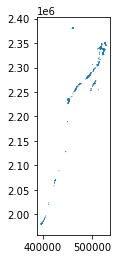

In [7]:
QRhotels_buffer_gdf.plot()

In [8]:
# Spatially Join the hotel buffers to Shore segment points
QRhotels_shorepts_join = gpd.sjoin(shore_points_gdf, QRhotels_buffer_gdf, op='intersects')
QRhotels_shorepts_join

,shore_desc,desc_abbrev,distance,shore_ptid,type_geomorph,seg_id,nearest_x,nearest_y,geometry,index_right,...,H_Rate_Exp,M_Rate_Exp,Cuartos,LRateTripa,HRateTripa,MinEmplead,MaxEmplead,MedEmplead,Municipio_,QRhotel_id
0,Isla Mujeres,imu,10.0,imu_000010,sand,190,2.351487e+06,526079.020764,POINT (526079.021 2351487.282),902,...,0.0,0.0,13,40.0,55.0,1,5,3,IslaMujeres,903
2,Isla Mujeres,imu,110.0,imu_000110,sand,190,2.351481e+06,526050.024372,POINT (526050.024 2351480.878),902,...,0.0,0.0,13,40.0,55.0,1,5,3,IslaMujeres,903
3,Isla Mujeres,imu,160.0,imu_000160,sand,190,2.351494e+06,526015.595971,POINT (526015.596 2351494.100),902,...,0.0,0.0,13,40.0,55.0,1,5,3,IslaMujeres,903
4,Isla Mujeres,imu,210.0,imu_000210,sand,190,2.351456e+06,526010.366221,POINT (526010.366 2351455.699),902,...,0.0,0.0,13,40.0,55.0,1,5,3,IslaMujeres,903
5,Isla Mujeres,imu,260.0,imu_000260,sand,190,2.351411e+06,526016.632782,POINT (526016.633 2351411.256),902,...,0.0,0.0,13,40.0,55.0,1,5,3,IslaMujeres,903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25910,Cozumel,coz,123760.0,coz_123760,sand,107,2.272914e+06,508708.742720,POINT (508708.743 2272913.927),296,...,90.3,86.0,143,0.0,0.0,0,None,134,Cozumel,297
25911,Cozumel,coz,123810.0,coz_123810,sand,107,2.272922e+06,508758.073717,POINT (508758.074 2272921.986),296,...,90.3,86.0,143,0.0,0.0,0,None,134,Cozumel,297
25912,Cozumel,coz,123860.0,coz_123860,sand,107,2.272929e+06,508807.591370,POINT (508807.591 2272928.915),296,...,90.3,86.0,143,0.0,0.0,0,None,134,Cozumel,297
25913,Cozumel,coz,123910.0,coz_123910,sand,107,2.272933e+06,508857.330505,POINT (508857.331 2272933.035),296,...,90.3,86.0,143,0.0,0.0,0,None,134,Cozumel,297


## Borja Hotel Data Summaries by Segment and Point ID

In [9]:
# Count of Unique Hotels by SEGMENT
hotel_count_seg_df = QRhotels_shorepts_join.groupby(['seg_id'])['QRhotel_id'].nunique().reset_index()
hotel_count_seg_df.rename(columns={'QRhotel_id': 'hotel_cnt'}, inplace=True)
hotel_count_seg_df

,seg_id,hotel_cnt
0,1,8
1,4,1
2,7,3
3,12,8
4,18,4
...,...,...
98,190,49
99,191,23
100,192,16
101,195,32


In [10]:
# Count by star rating and by SEGMENT
hotel_rating_seg_df = QRhotels_shorepts_join.groupby(['seg_id','StarRating'])['QRhotel_id'].nunique().reset_index()
hotel_rating_seg_df.rename(columns={'QRhotel_id': 'htlstar_cnt'}, inplace=True)
hotel_rating_seg_df

,seg_id,StarRating,htlstar_cnt
0,1,0.0,1
1,1,2.5,1
2,1,3.0,3
3,1,4.0,3
4,4,0.0,1
...,...,...,...
339,197,2.5,1
340,197,3.0,2
341,197,3.5,1
342,197,4.0,4


In [11]:
# Count of 5-star hotels within buffer distance of SEGMENT
hotel_5star_seg_df = QRhotels_shorepts_join[(QRhotels_shorepts_join['StarRating'] == 5)].groupby(
    ['seg_id'])['QRhotel_id'].nunique().reset_index()
hotel_5star_seg_df.rename(columns={'QRhotel_id': 'h5star_cnt'}, inplace=True)
hotel_5star_seg_df

,seg_id,h5star_cnt
0,36,3
1,44,1
2,45,4
3,46,1
4,47,1
5,122,3
6,124,1
7,128,1
8,129,1
9,130,1


In [12]:
# Count of hotels within buffer distance by POINT
hotel_count_pt_df = QRhotels_shorepts_join.groupby(['shore_ptid'])['QRhotel_id'].nunique().reset_index()
hotel_count_pt_df.rename(columns={'QRhotel_id': 'hotel_cnt'}, inplace=True)
hotel_count_pt_df

,shore_ptid,hotel_cnt
0,coz_060460,1
1,coz_060510,1
2,coz_060560,1
3,coz_060610,1
4,coz_060660,1
...,...,...
4372,qrm_754510,3
4373,qrm_754560,3
4374,qrm_754610,2
4375,qrm_754660,1


In [13]:
# Count of 5-star hotels within buffer distance by POINT
hotel_5star_pt_df = QRhotels_shorepts_join[(QRhotels_shorepts_join['StarRating'] == 5)].groupby(
    ['shore_ptid'])['QRhotel_id'].nunique().reset_index()
hotel_5star_pt_df.rename(columns={'QRhotel_id': 'h5star_cnt'}, inplace=True)
hotel_5star_pt_df

,shore_ptid,h5star_cnt
0,qrm_664510,3
1,qrm_664560,3
2,qrm_664610,3
3,qrm_664660,3
4,qrm_664710,3
...,...,...
403,qrm_754510,3
404,qrm_754560,3
405,qrm_754610,2
406,qrm_754660,1


## DENUE

In [14]:
# Load INEGI DENUE data  (source in epsg:6365)
denue_gdf = gpd.read_file('/Users/arbailey/natcap/idb/data/source/inegi/denue/denue_23/conjunto_de_datos/denue.shp').to_crs({'init': 'epsg:32616'})
print(denue_gdf.crs)
print(denue_gdf.dtypes)
# relevant columns are: 
denue_cols = ['d_llave', 'nom_est', 'cve_scian', 'desc_scian','sector','geometry']
# d_llave -- unique id
# nom_est -- establishment name
# cve_scian - NAICS code
# desc_scian -- NAICS description
# sector
denue_gdf = denue_gdf[denue_cols]
denue_gdf

{'init': 'epsg:32616'}
d_llave          int64
cve_ent         object
nom_ent         object
cve_mun         object
nom_mun         object
cve_loc         object
nom_loc         object
cve_ageb        object
manzana         object
nom_est         object
raz_soc         object
tipovial        object
nomvial         object
tiporef1        object
nomref1         object
tiporef2        object
nomref2         object
tiporef3        object
nomref3         object
numextnum       object
numextalf       object
numintnum       object
numintalf       object
tipoasen        object
nomasen         object
edif_nom        object
edif_piso       object
cp              object
tel_1           object
cve_scian       object
desc_scian      object
sector          object
tipo_cori       object
cor_indust      object
local           object
dir_elec_1      object
sitio_web       object
facebook        object
twitter         object
tipo_est        object
estr_poc        object
fecha_alta      object
coord_x    

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry
0,6384383,HOTEL COLONIAL SAN CARLOS,721112,Hoteles sin otros servicios integrados,72,POINT (517944.023 2340691.007)
1,6312675,PANALPINA SERVICIOS,561330,Suministro de personal permanente,56,POINT (526350.130 2337054.328)
2,3646950,CONSULTORIO DENTAL,621211,Consultorios dentales del sector privado,62,POINT (491879.968 2280684.123)
3,9108120,MAFER REGALOS,465912,Comercio al por menor de regalos,46,POINT (516582.969 2340711.935)
4,3627296,BORDADOS Y ESTAMPADOS BYE,323119,Impresión de formas continuas y otros impresos,31,POINT (515983.496 2341706.323)
...,...,...,...,...,...,...
65606,3614529,CEMENTERIO MUNICIPAL,812322,Administración de cementerios pertenecientes a...,81,POINT (320331.248 2185142.738)
65607,8892489,SERVICIOS FUNERARIOS CAMPESTRE RECINTO EXEQUIAL,812310,Servicios funerarios,81,POINT (361187.852 2046695.491)
65608,8705529,FUNERARIA SAN PEDRO DE GUERRERO,812310,Servicios funerarios,81,POINT (515605.670 2340967.936)
65609,3614945,PANTEON MUNICIPAL EL RECUERDO,812322,Administración de cementerios pertenecientes a...,81,POINT (332522.061 2166690.435)


In [15]:
# Denue business type subsets (using NACIS code)
# Lodging -- "cve_scian" LIKE '721%'
denue_lodging_gdf = denue_gdf.copy()
denue_lodging_gdf = denue_lodging_gdf[(denue_lodging_gdf['cve_scian'].str.startswith('721'))]
denue_lodging_gdf['dnu_type'] = 'lodging'
denue_lodging_gdf

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry,dnu_type
0,6384383,HOTEL COLONIAL SAN CARLOS,721112,Hoteles sin otros servicios integrados,72,POINT (517944.023 2340691.007),lodging
218,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,POINT (526047.547 2350665.510),lodging
411,3642060,VILLAS DEJA BLUE,721312,Departamentos y casas amueblados con servicios...,72,POINT (504326.389 2266807.488),lodging
442,6383956,HOTEL PEPITA,721112,Hoteles sin otros servicios integrados,72,POINT (505397.687 2267714.779),lodging
592,6484081,POSADA LAMAR,721311,Pensiones y casas de huéspedes,72,POINT (452617.398 2229737.121),lodging
...,...,...,...,...,...,...,...
65143,3632435,CASA MEXICANA,721311,Pensiones y casas de huéspedes,72,POINT (519964.276 2342569.118),lodging
65144,8719868,HOTEL SUITS VERSALLES,721312,Departamentos y casas amueblados con servicios...,72,POINT (517682.435 2340444.655),lodging
65145,8839736,HOSTEL CAN,721311,Pensiones y casas de huéspedes,72,POINT (518543.561 2340312.234),lodging
65147,6871727,CAMPAMENTO RECREATIVO PLAYA AVENTURAS,721210,Campamentos y albergues recreativos,72,POINT (465314.287 2251802.299),lodging


In [16]:
# Food / Drink -- "cve_scian" LIKE '722%'
denue_foodbev_gdf = denue_gdf.copy()
denue_foodbev_gdf = denue_foodbev_gdf[(denue_gdf['cve_scian'].str.startswith('722'))]
denue_foodbev_gdf['dnu_type'] = 'food_bev'
denue_foodbev_gdf

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry,dnu_type
287,8889767,OLLAS Y SARTENES,722513,Restaurantes con servicio de preparación de an...,72,POINT (517730.736 2340097.703),food_bev
347,8367810,TAQUERIA NEZA,722514,Restaurantes con servicio de preparación de ta...,72,POINT (515812.937 2338176.540),food_bev
444,7861301,TEA CHIA,722513,Restaurantes con servicio de preparación de an...,72,POINT (505553.694 2268195.518),food_bev
447,7849790,TAQUERIA CAMILA,722514,Restaurantes con servicio de preparación de ta...,72,POINT (353176.978 2066313.997),food_bev
449,3642377,ANTOJITOS DOÑA DALI,722513,Restaurantes con servicio de preparación de an...,72,POINT (504839.782 2267425.673),food_bev
...,...,...,...,...,...,...,...
65267,8915849,RESTAURANT HUNAB KU,722511,Restaurantes con servicio de preparación de al...,72,POINT (473595.116 2265586.003),food_bev
65269,3632110,PIANO BAR BRONCOS,722412,"Bares, cantinas y similares",72,POINT (527290.768 2348531.347),food_bev
65270,3623832,BAR EL PESCADOR,722412,"Bares, cantinas y similares",72,POINT (505728.855 2266727.151),food_bev
65271,7931856,SUBWAY,722516,Restaurantes de autoservicio,72,POINT (493035.009 2281406.187),food_bev


In [17]:
# Entertainment & Recreation -- "cve_scian" LIKE '71%'
denue_entrec_gdf = denue_gdf.copy()
denue_entrec_gdf = denue_entrec_gdf[(denue_gdf['cve_scian'].str.startswith('71'))]
denue_entrec_gdf['dnu_type'] = 'ent_rec'
denue_entrec_gdf

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry,dnu_type
52,3662199,LA BOLITA,713291,"Venta de billetes de lotería, pronósticos depo...",71,POINT (517406.811 2342536.841),ent_rec
101,3624050,BUNKER CROSSFIT,713943,Centros de acondicionamiento físico del sector...,71,POINT (505086.304 2265568.266),ent_rec
122,3631978,MEXICO DIVERS,713998,Otros servicios recreativos prestados por el s...,71,POINT (526245.408 2350627.635),ent_rec
140,3638326,GIM POWER,713943,Centros de acondicionamiento físico del sector...,71,POINT (364449.933 2048735.730),ent_rec
190,6452388,TORO IVESTMENT CONSTRUCCION,713930,Marinas turísticas,71,POINT (520224.790 2340530.908),ent_rec
...,...,...,...,...,...,...,...
65009,8618054,CENTRO DE ACONDICIONAMIENTO FISICO DEL SECTOR ...,713943,Centros de acondicionamiento físico del sector...,71,POINT (364945.917 2049350.528),ent_rec
65010,8193446,LA BOLITA PRONOSTICO,713291,"Venta de billetes de lotería, pronósticos depo...",71,POINT (507106.892 2267293.302),ent_rec
65011,7833593,CENTRO DE ENTRENAMIENTO GENOMA,713943,Centros de acondicionamiento físico del sector...,71,POINT (492206.668 2283881.479),ent_rec
65012,3658171,LOTERIA NACIONAL,713291,"Venta de billetes de lotería, pronósticos depo...",71,POINT (513185.518 2341473.099),ent_rec


In [18]:
# Buffer DENUE data
# Copy the point data for for the attributes, then run the buffer
denue_lodging_buffer_gdf = denue_lodging_gdf.copy()
denue_lodging_buffer_gdf['geometry'] = denue_lodging_gdf['geometry'].buffer(buffer_distance)
denue_foodbev_buffer_gdf = denue_foodbev_gdf.copy()
denue_foodbev_buffer_gdf['geometry'] = denue_foodbev_gdf['geometry'].buffer(buffer_distance)
denue_entrec_buffer_gdf = denue_entrec_gdf.copy()
denue_entrec_buffer_gdf['geometry'] = denue_entrec_gdf['geometry'].buffer(buffer_distance)

In [19]:
denue_entrec_buffer_gdf

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry,dnu_type
52,3662199,LA BOLITA,713291,"Venta de billetes de lotería, pronósticos depo...",71,"POLYGON ((518406.811 2342536.841, 518401.996 2...",ent_rec
101,3624050,BUNKER CROSSFIT,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((506086.304 2265568.266, 506081.489 2...",ent_rec
122,3631978,MEXICO DIVERS,713998,Otros servicios recreativos prestados por el s...,71,"POLYGON ((527245.408 2350627.635, 527240.593 2...",ent_rec
140,3638326,GIM POWER,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((365449.933 2048735.730, 365445.118 2...",ent_rec
190,6452388,TORO IVESTMENT CONSTRUCCION,713930,Marinas turísticas,71,"POLYGON ((521224.790 2340530.908, 521219.975 2...",ent_rec
...,...,...,...,...,...,...,...
65009,8618054,CENTRO DE ACONDICIONAMIENTO FISICO DEL SECTOR ...,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((365945.917 2049350.528, 365941.102 2...",ent_rec
65010,8193446,LA BOLITA PRONOSTICO,713291,"Venta de billetes de lotería, pronósticos depo...",71,"POLYGON ((508106.892 2267293.302, 508102.077 2...",ent_rec
65011,7833593,CENTRO DE ENTRENAMIENTO GENOMA,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((493206.668 2283881.479, 493201.853 2...",ent_rec
65012,3658171,LOTERIA NACIONAL,713291,"Venta de billetes de lotería, pronósticos depo...",71,"POLYGON ((514185.518 2341473.099, 514180.702 2...",ent_rec


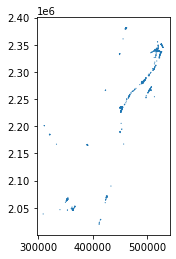

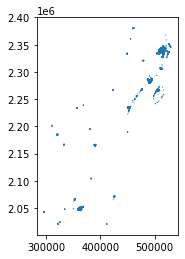

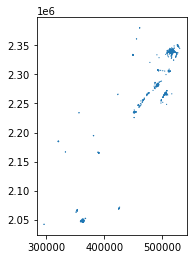

In [20]:
denue_lodging_buffer_gdf.plot()
denue_foodbev_buffer_gdf.plot()
denue_entrec_buffer_gdf.plot()

In [21]:
# Combine all the DENUE buffers into a single GDF
denue_buffered = pd.concat([denue_lodging_buffer_gdf, denue_foodbev_buffer_gdf, denue_entrec_buffer_gdf], axis=0, ignore_index=True)
denue_buffered

,d_llave,nom_est,cve_scian,desc_scian,sector,geometry,dnu_type
0,6384383,HOTEL COLONIAL SAN CARLOS,721112,Hoteles sin otros servicios integrados,72,"POLYGON ((518944.023 2340691.007, 518939.208 2...",lodging
1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,"POLYGON ((527047.547 2350665.510, 527042.732 2...",lodging
2,3642060,VILLAS DEJA BLUE,721312,Departamentos y casas amueblados con servicios...,72,"POLYGON ((505326.389 2266807.488, 505321.574 2...",lodging
3,6383956,HOTEL PEPITA,721112,Hoteles sin otros servicios integrados,72,"POLYGON ((506397.687 2267714.779, 506392.872 2...",lodging
4,6484081,POSADA LAMAR,721311,Pensiones y casas de huéspedes,72,"POLYGON ((453617.398 2229737.121, 453612.583 2...",lodging
...,...,...,...,...,...,...,...
12303,8618054,CENTRO DE ACONDICIONAMIENTO FISICO DEL SECTOR ...,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((365945.917 2049350.528, 365941.102 2...",ent_rec
12304,8193446,LA BOLITA PRONOSTICO,713291,"Venta de billetes de lotería, pronósticos depo...",71,"POLYGON ((508106.892 2267293.302, 508102.077 2...",ent_rec
12305,7833593,CENTRO DE ENTRENAMIENTO GENOMA,713943,Centros de acondicionamiento físico del sector...,71,"POLYGON ((493206.668 2283881.479, 493201.853 2...",ent_rec
12306,3658171,LOTERIA NACIONAL,713291,"Venta de billetes de lotería, pronósticos depo...",71,"POLYGON ((514185.518 2341473.099, 514180.702 2...",ent_rec


In [22]:
# Spatially Join the DENUE lodging/food/entertainment buffers to Shore segment points
denue_shorepts_join = gpd.sjoin(shore_points_gdf, denue_buffered, op='intersects')
denue_shorepts_join

,shore_desc,desc_abbrev,distance,shore_ptid,type_geomorph,seg_id,nearest_x,nearest_y,geometry,index_right,d_llave,nom_est,cve_scian,desc_scian,sector,dnu_type
0,Isla Mujeres,imu,10.0,imu_000010,sand,190,2.351487e+06,526079.020764,POINT (526079.021 2351487.282),1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,lodging
1,Isla Mujeres,imu,60.0,imu_000060,sand,190,2.351521e+06,526069.071721,POINT (526069.072 2351520.957),1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,lodging
2,Isla Mujeres,imu,110.0,imu_000110,sand,190,2.351481e+06,526050.024372,POINT (526050.024 2351480.878),1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,lodging
3,Isla Mujeres,imu,160.0,imu_000160,sand,190,2.351494e+06,526015.595971,POINT (526015.596 2351494.100),1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,lodging
4,Isla Mujeres,imu,210.0,imu_000210,sand,190,2.351456e+06,526010.366221,POINT (526010.366 2351455.699),1,6384240,HOSPEDAJE MARIA LETICIA,721311,Pensiones y casas de huéspedes,72,lodging
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25927,Cozumel,coz,124610.0,coz_124610,cliff or rocky,106,2.273172e+06,509512.050846,POINT (509512.051 2273172.223),3440,3642700,RESTAURANT BARRACURA,722513,Restaurantes con servicio de preparación de an...,72,food_bev
25928,Cozumel,coz,124660.0,coz_124660,cliff or rocky,106,2.273193e+06,509557.181006,POINT (509557.181 2273193.291),3440,3642700,RESTAURANT BARRACURA,722513,Restaurantes con servicio de preparación de an...,72,food_bev
25929,Cozumel,coz,124710.0,coz_124710,cliff or rocky,106,2.273217e+06,509601.279467,POINT (509601.279 2273216.836),3440,3642700,RESTAURANT BARRACURA,722513,Restaurantes con servicio de preparación de an...,72,food_bev
25930,Cozumel,coz,124760.0,coz_124760,cliff or rocky,106,2.273239e+06,509646.287052,POINT (509646.287 2273238.615),3440,3642700,RESTAURANT BARRACURA,722513,Restaurantes con servicio de preparación de an...,72,food_bev


In [23]:
# Group by different DENUE types -- SEGMENT
# Lodging
denue_lodging_count_seg_df = denue_shorepts_join[(denue_shorepts_join['dnu_type'] == 'lodging')].groupby(
    ['seg_id'])['d_llave'].nunique().reset_index()
denue_lodging_count_seg_df.rename(columns={'d_llave': 'lodge_cnt'}, inplace=True)
print(denue_lodging_count_seg_df.head())
# Food & Beverage
denue_foodbev_count_seg_df = denue_shorepts_join[(denue_shorepts_join['dnu_type'] == 'food_bev')].groupby(
    ['seg_id'])['d_llave'].nunique().reset_index()
denue_foodbev_count_seg_df.rename(columns={'d_llave': 'fdbev_cnt'}, inplace=True)
print(denue_foodbev_count_seg_df.head())
# Entertainment and Recreation
denue_entrec_count_seg_df = denue_shorepts_join[(denue_shorepts_join['dnu_type'] == 'ent_rec')].groupby(
    ['seg_id'])['d_llave'].nunique().reset_index()
denue_entrec_count_seg_df.rename(columns={'d_llave': 'entrec_cnt'}, inplace=True)
print(denue_entrec_count_seg_df.head())

   seg_id  lodge_cnt
0       1          8
1       4          1
2       7          6
3      12          6
4      18          6
   seg_id  fdbev_cnt
0       1         25
1       7         39
2      12         16
3      14          4
4      18          2
   seg_id  entrec_cnt
0       1           2
1      12          14
2      15           1
3      16           1
4      17           1


In [24]:
# Group by different DENUE types -- POINT
# Lodging
denue_lodging_count_pt_df = denue_shorepts_join[(denue_shorepts_join['dnu_type'] == 'lodging')].groupby(
    ['shore_ptid'])['d_llave'].nunique().reset_index()
denue_lodging_count_pt_df.rename(columns={'d_llave': 'lodge_cnt'}, inplace=True)
print(denue_lodging_count_pt_df.head())
# Food & Beverage
denue_foodbev_count_pt_df = denue_shorepts_join[(denue_shorepts_join['dnu_type'] == 'food_bev')].groupby(
    ['shore_ptid'])['d_llave'].nunique().reset_index()
denue_foodbev_count_pt_df.rename(columns={'d_llave': 'fdbev_cnt'}, inplace=True)
print(denue_foodbev_count_pt_df.head())
# Entertainment and Recreation
denue_entrec_count_pt_df = denue_shorepts_join[(denue_shorepts_join['dnu_type'] == 'ent_rec')].groupby(
    ['shore_ptid'])['d_llave'].nunique().reset_index()
denue_entrec_count_pt_df.rename(columns={'d_llave': 'entrec_cnt'}, inplace=True)
print(denue_entrec_count_pt_df.head())
denue_entrec_count_pt_df.describe()

   shore_ptid  lodge_cnt
0  coz_060510          1
1  coz_060560          1
2  coz_060610          1
3  coz_060660          1
4  coz_060710          1
   shore_ptid  fdbev_cnt
0  coz_000010          1
1  coz_000060          1
2  coz_000110          1
3  coz_000160          1
4  coz_000210          1
   shore_ptid  entrec_cnt
0  coz_091660           1
1  coz_091710           1
2  coz_091760           1
3  coz_091810           1
4  coz_091860           1


,entrec_cnt
count,2899.000000
mean,5.126595
std,7.467725
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,47.000000


# Find Distance to Nearest

In [25]:
# https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbour.html - NOT USED
# Adapted from https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html

from sklearn.neighbors import BallTree

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    # Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric
    # but useful as we get the distance between points in meters.  It requires radians as input
    # Non-projected coordinates (geographic)
#     tree = BallTree(candidates, leaf_size=15, metric='haversine')
    # Projected coordinates
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)

    # Parse coordinates from points and insert them into a numpy array as RADIANS
#     left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
#     right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
#     print(left_radians)
    # Parse coordinates from points and insert them into a numpy array - assume projected CRS
    left_xys = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x, geom.y)).to_list())
    right_xys = np.array(right[right_geom_col].apply(lambda geom: (geom.x, geom.y)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

#     closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)
    closest, dist = get_nearest(src_points=left_xys, candidates=right_xys)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points_gdf = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points_gdf = closest_points_gdf.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians (if input in Geographic Coord)
#         earth_radius = 6371000  # meters
#         closest_points_gdf['distance'] = dist * earth_radius
        # In projected Coordinate System coordinates
        closest_points_gdf['distance'] = dist
        
    return closest_points_gdf

In [26]:
#  Get distance to closest DENUE points
# lodging
closest_lodging_gdf = nearest_neighbor(shore_points_gdf, denue_lodging_gdf, return_dist=True)
closest_lodging_gdf = closest_lodging_gdf.rename(
    columns={'geometry': 'lodge_geom', 'distance': 'lodge_dist'})
closest_lodging_gdf
# Food / Bev
closest_foodbev_gdf = nearest_neighbor(shore_points_gdf, denue_foodbev_gdf, return_dist=True)
closest_foodbev_gdf = closest_foodbev_gdf.rename(
    columns={'geometry': 'fdbev_geom', 'distance': 'fdbev_dist'})
closest_foodbev_gdf
# Recreation / Entertainment
closest_entrec_gdf = nearest_neighbor(shore_points_gdf, denue_entrec_gdf, return_dist=True)
closest_entrec_gdf = closest_entrec_gdf.rename(
    columns={'geometry': 'entrec_geom', 'distance': 'entrec_dist'})
closest_entrec_gdf

,d_llave,nom_est,cve_scian,desc_scian,sector,entrec_geom,dnu_type,entrec_dist
0,7831524,CENTRO DE CONVENCIONES DE ISLA MUJERES,711312,Promotores del sector público de espectáculos ...,71,POINT (525951.637 2350976.565),ent_rec,526.364060
1,7831524,CENTRO DE CONVENCIONES DE ISLA MUJERES,711312,Promotores del sector público de espectáculos ...,71,POINT (525951.637 2350976.565),ent_rec,556.914721
2,7831524,CENTRO DE CONVENCIONES DE ISLA MUJERES,711312,Promotores del sector público de espectáculos ...,71,POINT (525951.637 2350976.565),ent_rec,513.820891
3,7831524,CENTRO DE CONVENCIONES DE ISLA MUJERES,711312,Promotores del sector público de espectáculos ...,71,POINT (525951.637 2350976.565),ent_rec,521.472675
4,7831524,CENTRO DE CONVENCIONES DE ISLA MUJERES,711312,Promotores del sector público de espectáculos ...,71,POINT (525951.637 2350976.565),ent_rec,482.720773
...,...,...,...,...,...,...,...,...
26102,6491651,PARADOR TURISTICO SAN GERVACIO,713999,Otros servicios recreativos prestados por el s...,71,POINT (516154.202 2266631.044),ent_rec,5490.570550
26103,6491651,PARADOR TURISTICO SAN GERVACIO,713999,Otros servicios recreativos prestados por el s...,71,POINT (516154.202 2266631.044),ent_rec,5539.067704
26104,6491651,PARADOR TURISTICO SAN GERVACIO,713999,Otros servicios recreativos prestados por el s...,71,POINT (516154.202 2266631.044),ent_rec,5587.546940
26105,6491651,PARADOR TURISTICO SAN GERVACIO,713999,Otros servicios recreativos prestados por el s...,71,POINT (516154.202 2266631.044),ent_rec,5623.158538


In [27]:
# Load Additional Amenities/Infrastructure Layers
# Roads
roads_gdf = gpd.read_file('/Users/arbailey/natcap/idb/data/source/sama/Tourism_MAR_ToT_Data_QGIS/InVEST_inputs/roads_MAR_clip_32616.shp')
roads_pts_gdf = gpd.read_file(shore_gpkg, layer='roads_QR_NatCap_10m_pts')
# Airports and Ports
airsea_gdf = gpd.read_file('/Users/arbailey/natcap/idb/data/source/sama/Tourism_MAR_ToT_Data_QGIS/InVEST_inputs/ports_air_32616.shp').to_crs({'init': 'epsg:32616'})
# Archaeological Sites
arch_gdf = gpd.read_file('/Users/arbailey/natcap/idb/data/source/sama/Tourism_MAR_ToT_Data_QGIS/InVEST_inputs/archaeological_sites_combined_32616.shp')
print(airsea_gdf.crs)
print(airsea_gdf.dtypes)
airsea_gdf
air_gdf = airsea_gdf[airsea_gdf['airsea'] == 'Airport']
air_gdf
port_gdf = airsea_gdf[airsea_gdf['airsea'] == 'Port']
port_gdf
roads_gdf
arch_gdf
roads_pts_gdf

{'init': 'epsg:32616'}
name          object
type          object
comments      object
country       object
airsea        object
geometry    geometry
dtype: object


,osm_id,name,ref,type,oneway,bridge,tunnel,maxspeed,layer,path,distance,angle,geometry
0,49313343,Barrier Reef Drive,None,primary,0.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,0.0,34.791519,POINT (397957.372 1981293.864)
1,49313343,Barrier Reef Drive,None,primary,0.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,10.0,34.791519,POINT (397963.078 1981302.076)
2,49313343,Barrier Reef Drive,None,primary,0.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,20.0,34.791519,POINT (397968.783 1981310.288)
3,49313343,Barrier Reef Drive,None,primary,0.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,30.0,34.791519,POINT (397974.489 1981318.501)
4,49313343,Barrier Reef Drive,None,primary,0.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,40.0,34.791519,POINT (397980.195 1981326.713)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230829,None,None,None,secondary,NaN,NaN,NaN,NaN,drawn by SGW 121919,None,48070.0,125.959401,POINT (491435.308 2284152.656)
230830,None,None,None,secondary,NaN,NaN,NaN,NaN,drawn by SGW 121919,None,48080.0,125.959401,POINT (491443.402 2284146.784)
230831,None,None,None,secondary,NaN,NaN,NaN,NaN,drawn by SGW 121919,None,48090.0,125.959401,POINT (491451.497 2284140.912)
230832,None,None,None,secondary,NaN,NaN,NaN,NaN,drawn by SGW 121919,None,48100.0,125.959401,POINT (491459.591 2284135.040)


In [28]:
#  Get distance to closest transportation & archaelogical points
# roads
closest_road_gdf = nearest_neighbor(shore_points_gdf, roads_pts_gdf, return_dist=True)
closest_road_gdf = closest_road_gdf.rename(
    columns={'geometry': 'road_geom', 'distance': 'road_dist'})
# airport
closest_air_gdf = nearest_neighbor(shore_points_gdf, air_gdf, return_dist=True)
closest_air_gdf = closest_air_gdf.rename(
    columns={'geometry': 'air_geom', 'distance': 'air_dist'})
closest_air_gdf
# ports
closest_port_gdf = nearest_neighbor(shore_points_gdf, port_gdf, return_dist=True)
closest_port_gdf = closest_port_gdf.rename(
    columns={'geometry': 'port_geom', 'distance': 'port_dist'})
closest_port_gdf
# archaeological sites
closest_arch_gdf = nearest_neighbor(shore_points_gdf, arch_gdf, return_dist=True)
closest_arch_gdf = closest_arch_gdf.rename(
    columns={'geometry': 'arch_geom', 'distance': 'arch_dist'})
closest_arch_gdf
closest_road_gdf

,osm_id,name,ref,type,oneway,bridge,tunnel,maxspeed,layer,path,road_dist,angle,road_geom
0,47233533,Rueda Medina,None,primary,0.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,895.937107,110.396568,POINT (525827.310 2350627.431)
1,47233533,Rueda Medina,None,primary,0.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,925.655633,110.396568,POINT (525827.310 2350627.431)
2,47233533,Rueda Medina,None,primary,0.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,882.028372,110.396568,POINT (525827.310 2350627.431)
3,47233533,Rueda Medina,None,primary,0.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,886.886609,110.396568,POINT (525827.310 2350627.431)
4,47233533,Rueda Medina,None,primary,0.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,848.256512,110.396568,POINT (525827.310 2350627.431)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26102,34023656,None,None,secondary,1.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,8720.870697,321.397362,POINT (507094.969 2267955.811)
26103,34023656,None,None,secondary,1.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,8720.460121,321.397362,POINT (507094.969 2267955.811)
26104,34023656,None,None,secondary,1.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,8720.248816,321.397362,POINT (507094.969 2267955.811)
26105,34023656,None,None,secondary,1.0,0.0,0.0,NaN,roads,/home/sgwinder/Documents/MAR/GIS/Predictors/In...,8694.718512,321.397362,POINT (507094.969 2267955.811)


# Join Attributes with Segments and Points

In [29]:
# Merge the closest gdfs back to the shore points gdf by index 
columns = ['shore_ptid', 'seg_id', 'type_geomorph', 'shore_desc', 'desc_abbrev', 'distance', 'geometry']
att_columns = [
    'lodge_dist',
    'fdbev_dist', 
    'entrec_dist', 
    'road_dist',
    'air_dist', 
    'port_dist',
    'arch_dist'
]
columns.extend(att_columns)
closest_dfs = [shore_points_gdf, 
               closest_lodging_gdf, 
               closest_foodbev_gdf,
               closest_entrec_gdf,
               closest_road_gdf,
               closest_air_gdf,
               closest_port_gdf,
               closest_arch_gdf,
              ]
nearest_shorept_df = pd.concat(closest_dfs, axis=1)
print(nearest_shorept_df.info())
nearest_shorept_df = nearest_shorept_df[columns]
nearest_shorept_df

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 26107 entries, 0 to 26106
Data columns (total 97 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   shore_desc     26107 non-null  object  
 1   desc_abbrev    26107 non-null  object  
 2   distance       26107 non-null  float64 
 3   shore_ptid     26107 non-null  object  
 4   type_geomorph  26107 non-null  object  
 5   seg_id         26107 non-null  int64   
 6   nearest_x      26107 non-null  float64 
 7   nearest_y      26107 non-null  float64 
 8   geometry       26107 non-null  geometry
 9   d_llave        26107 non-null  int64   
 10  nom_est        26097 non-null  object  
 11  cve_scian      26107 non-null  object  
 12  desc_scian     26107 non-null  object  
 13  sector         26107 non-null  object  
 14  lodge_geom     26107 non-null  geometry
 15  dnu_type       26107 non-null  object  
 16  lodge_dist     26107 non-null  float64 
 17  d_llave        26107 no

,shore_ptid,seg_id,type_geomorph,shore_desc,desc_abbrev,distance,geometry,lodge_dist,fdbev_dist,entrec_dist,road_dist,air_dist,port_dist,arch_dist
0,imu_000010,190,sand,Isla Mujeres,imu,10.0,POINT (526079.021 2351487.282),241.819938,344.783187,526.364060,895.937107,2217.254990,1103.440696,8268.627318
1,imu_000060,190,sand,Isla Mujeres,imu,60.0,POINT (526069.072 2351520.957),275.027006,371.737434,556.914721,925.655633,2252.246099,1138.123073,8285.974246
2,imu_000110,190,sand,Isla Mujeres,imu,110.0,POINT (526050.024 2351480.878),235.232893,327.472439,513.820891,882.028372,2222.008264,1101.184350,8243.882369
3,imu_000160,190,sand,Isla Mujeres,imu,160.0,POINT (526015.596 2351494.100),252.574759,329.472369,521.472675,886.886609,2247.347102,1120.012135,8229.591058
4,imu_000210,190,sand,Isla Mujeres,imu,210.0,POINT (526010.366 2351455.699),216.186190,291.038590,482.720773,848.256512,2214.037157,1083.276295,8198.243324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26102,coz_133360,187,cliff or rocky,Cozumel,coz,133360.0,POINT (514841.054 2271962.273),6879.575404,811.560312,5490.570550,8720.870697,8514.854767,10909.201087,7189.185094
26103,coz_133410,187,cliff or rocky,Cozumel,coz,133410.0,POINT (514817.593 2272006.427),6852.389184,782.999591,5539.067704,8720.460121,8514.166116,10904.605619,7238.786623
26104,coz_133460,187,cliff or rocky,Cozumel,coz,133460.0,POINT (514794.066 2272050.519),6825.400113,756.604667,5587.546940,8720.248816,8513.683787,10900.152547,7288.358760
26105,coz_133510,187,cliff or rocky,Cozumel,coz,133510.0,POINT (514751.275 2272076.382),6780.777627,713.261067,5623.158538,8694.718512,8487.925909,10871.016694,7327.807367


In [30]:
nearest_shorept_df['road_dist'].describe()

count    26107.000000
mean     15343.494129
std      14190.840028
min          0.665704
25%       1730.891497
50%      11815.684382
75%      27536.559677
max      47901.836889
Name: road_dist, dtype: float64

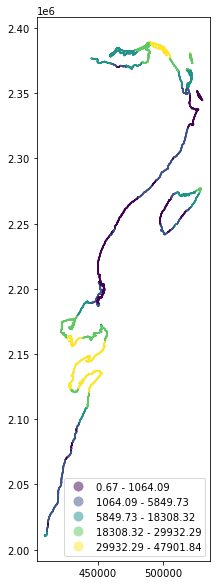

In [31]:
nearest_shorept_df.plot(column='road_dist', markersize=0.2, alpha=0.5, figsize=(10,10), scheme='quantiles', k=5,
               legend=True)

# Summarize Attributes By Segment ID and Join to Segments

In [32]:
columns = ['shore_ptid', 'seg_id', 'type_geomorph', 'shore_desc', 'desc_abbrev', 'distance', 'geometry']
att_columns = [
    'lodge_dist',
    'fdbev_dist', 
    'entrec_dist', 
    'road_dist',
    'air_dist', 
    'port_dist',
    'arch_dist'
]

# Summarize attributes by segment ID
nearest_by_seg_df = nearest_shorept_df.groupby(
    ['seg_id']).agg(
    lodge_dist_avg = ('lodge_dist', np.mean),
    lodge_dist_min = ('lodge_dist', np.min),
    fdbev_dist_avg = ('fdbev_dist', np.mean),
    fdbev_dist_min = ('fdbev_dist', np.min),
    entrec_dist_avg = ('entrec_dist', np.mean),
    entrec_dist_min = ('entrec_dist', np.min),
    road_dist_avg = ('road_dist', np.mean),
    road_dist_min = ('road_dist', np.min),
    air_dist_avg = ('air_dist', np.mean),
    air_dist_min = ('air_dist', np.min),
    port_dist_avg = ('port_dist', np.mean),
    port_dist_min = ('port_dist', np.min),
    arch_dist_avg = ('arch_dist', np.mean),
    arch_dist_min = ('arch_dist', np.min),    
).reset_index()
nearest_by_seg_df

,seg_id,lodge_dist_avg,lodge_dist_min,fdbev_dist_avg,fdbev_dist_min,entrec_dist_avg,entrec_dist_min,road_dist_avg,road_dist_min,air_dist_avg,air_dist_min,port_dist_avg,port_dist_min,arch_dist_avg,arch_dist_min
0,1,340.573165,75.891378,183.223977,9.396596,701.131339,111.789587,175.927856,60.313870,4901.486583,3896.646870,6071.671173,5061.465465,8881.350621,8206.371959
1,2,21685.458113,20040.405578,9644.051322,8051.040398,26627.563101,24879.344959,26951.101589,25203.619970,28326.215455,26576.104596,27248.847630,25500.037911,31692.827347,30003.635994
2,3,39275.699139,37464.806343,57915.128829,56382.265568,58161.289099,56581.621952,36408.053556,34482.741269,112585.630856,110425.332125,58512.347123,56585.253897,72370.669368,70154.113149
3,4,2394.544656,45.199576,17104.816529,14474.688524,17354.032026,14731.852121,2198.339863,1848.306230,71563.644173,68914.508070,17218.818278,14572.717618,63650.257187,63324.043106
4,5,6599.576860,5605.725873,6914.935268,5922.089689,56761.611064,56066.412958,7240.844220,6247.767933,7303.519010,6372.399671,7844.540582,6850.735859,56565.651556,56399.828412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,193,12744.984489,10478.485723,12477.132644,10201.512991,14321.789305,12111.068714,16723.929091,15233.370919,13742.647852,11506.297012,14447.201968,12253.713500,79427.942538,77064.227175
193,194,30363.862436,26907.994886,30461.735131,27388.675524,32058.419895,28625.855099,32261.553685,29453.459691,32658.382886,29243.410081,31860.694184,28492.245492,51339.147214,48393.648134
194,195,421.694273,26.068742,1365.894782,29.023918,3016.754459,57.512489,2683.627167,2239.986274,17260.461876,12918.624392,5181.820917,101.759803,21117.707580,15880.045690
195,196,6339.538270,6016.541954,290.342143,78.274052,5752.584909,5639.422784,8317.131022,8067.994118,8109.212134,7859.112066,10473.913779,10205.675063,7513.413717,7354.414681


In [33]:
# Join segement summarized metrics to segment layer - counts and distances
dfs = [df.set_index(['seg_id']) for df in [shore_segments_gdf, 
                                           hotel_count_seg_df, hotel_5star_seg_df, 
                                           denue_lodging_count_seg_df, denue_foodbev_count_seg_df, denue_entrec_count_seg_df,
                                           nearest_by_seg_df]]
shore_segments_atts_gdf = pd.concat(dfs, axis=1).reset_index().fillna(0)
shore_segments_atts_gdf

,seg_id,type_geomorph,length_km,shore_desc,desc_abbrev,geometry,hotel_cnt,h5star_cnt,lodge_cnt,fdbev_cnt,...,entrec_dist_avg,entrec_dist_min,road_dist_avg,road_dist_min,air_dist_avg,air_dist_min,port_dist_avg,port_dist_min,arch_dist_avg,arch_dist_min
0,1,cliff or rocky,2.188708,Isla Mujeres,imu,"MULTILINESTRING ((530027.596 2344472.852, 5300...",8.0,0.0,8.0,25.0,...,701.131339,111.789587,175.927856,60.313870,4901.486583,3896.646870,6071.671173,5061.465465,8881.350621,8206.371959
1,2,sand,3.738697,Isla Contoy,ico,"MULTILINESTRING ((521010.617 2378995.910, 5210...",0.0,0.0,0.0,0.0,...,26627.563101,24879.344959,26951.101589,25203.619970,28326.215455,26576.104596,27248.847630,25500.037911,31692.827347,30003.635994
2,3,mixed mud and sand,5.758523,QR mainland,qrm,"MULTILINESTRING ((439281.990 2130747.294, 4392...",0.0,0.0,0.0,0.0,...,58161.289099,56581.621952,36408.053556,34482.741269,112585.630856,110425.332125,58512.347123,56585.253897,72370.669368,70154.113149
3,4,sand,5.622333,QR mainland,qrm,"MULTILINESTRING ((433485.994 2090201.431, 4334...",1.0,0.0,1.0,0.0,...,17354.032026,14731.852121,2198.339863,1848.306230,71563.644173,68914.508070,17218.818278,14572.717618,63650.257187,63324.043106
4,5,sand,2.136723,QR mainland,qrm,"MULTILINESTRING ((410987.143 2013924.228, 4109...",0.0,0.0,0.0,0.0,...,56761.611064,56066.412958,7240.844220,6247.767933,7303.519010,6372.399671,7844.540582,6850.735859,56565.651556,56399.828412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,193,cliff or rocky,5.019248,QR mainland,qrm,"MULTILINESTRING ((444590.092 2376499.228, 4447...",0.0,0.0,0.0,0.0,...,14321.789305,12111.068714,16723.929091,15233.370919,13742.647852,11506.297012,14447.201968,12253.713500,79427.942538,77064.227175
193,194,sand,8.177061,Holbox,hol,"MULTILINESTRING ((488231.217 2388467.313, 4882...",0.0,0.0,0.0,0.0,...,32058.419895,28625.855099,32261.553685,29453.459691,32658.382886,29243.410081,31860.694184,28492.245492,51339.147214,48393.648134
194,195,sand,11.078166,QR mainland,qrm,"MULTILINESTRING ((516830.778 2314283.226, 5168...",32.0,1.0,23.0,59.0,...,3016.754459,57.512489,2683.627167,2239.986274,17260.461876,12918.624392,5181.820917,101.759803,21117.707580,15880.045690
195,196,sand,0.784313,Isla de la Pasion,ipa,"MULTILINESTRING ((513991.173 2272135.231, 5139...",0.0,0.0,0.0,1.0,...,5752.584909,5639.422784,8317.131022,8067.994118,8109.212134,7859.112066,10473.913779,10205.675063,7513.413717,7354.414681


In [40]:
# Join point summarized metrics to point layer - counts and distances
dfs = [df.set_index(['shore_ptid']) for df in [nearest_shorept_df, 
                                               hotel_count_pt_df, hotel_5star_pt_df,
                                               denue_lodging_count_pt_df, denue_foodbev_count_pt_df, denue_entrec_count_pt_df,
                                           ]]
shore_points_atts_gdf = pd.concat(dfs, axis=1).reset_index().fillna(0)
shore_points_atts_gdf.rename(columns={'index': 'shore_ptid'}, inplace=True)
shore_points_atts_gdf

,shore_ptid,seg_id,type_geomorph,shore_desc,desc_abbrev,distance,geometry,lodge_dist,fdbev_dist,entrec_dist,road_dist,air_dist,port_dist,arch_dist,hotel_cnt,h5star_cnt,lodge_cnt,fdbev_cnt,entrec_cnt
0,imu_000010,190,sand,Isla Mujeres,imu,10.0,POINT (526079.021 2351487.282),241.819938,344.783187,526.364060,895.937107,2217.254990,1103.440696,8268.627318,34.0,0.0,37.0,120.0,10.0
1,imu_000060,190,sand,Isla Mujeres,imu,60.0,POINT (526069.072 2351520.957),275.027006,371.737434,556.914721,925.655633,2252.246099,1138.123073,8285.974246,32.0,0.0,35.0,111.0,10.0
2,imu_000110,190,sand,Isla Mujeres,imu,110.0,POINT (526050.024 2351480.878),235.232893,327.472439,513.820891,882.028372,2222.008264,1101.184350,8243.882369,34.0,0.0,37.0,120.0,10.0
3,imu_000160,190,sand,Isla Mujeres,imu,160.0,POINT (526015.596 2351494.100),252.574759,329.472369,521.472675,886.886609,2247.347102,1120.012135,8229.591058,34.0,0.0,36.0,114.0,10.0
4,imu_000210,190,sand,Isla Mujeres,imu,210.0,POINT (526010.366 2351455.699),216.186190,291.038590,482.720773,848.256512,2214.037157,1083.276295,8198.243324,34.0,0.0,37.0,121.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26102,coz_133360,187,cliff or rocky,Cozumel,coz,133360.0,POINT (514841.054 2271962.273),6879.575404,811.560312,5490.570550,8720.870697,8514.854767,10909.201087,7189.185094,0.0,0.0,0.0,1.0,0.0
26103,coz_133410,187,cliff or rocky,Cozumel,coz,133410.0,POINT (514817.593 2272006.427),6852.389184,782.999591,5539.067704,8720.460121,8514.166116,10904.605619,7238.786623,0.0,0.0,0.0,1.0,0.0
26104,coz_133460,187,cliff or rocky,Cozumel,coz,133460.0,POINT (514794.066 2272050.519),6825.400113,756.604667,5587.546940,8720.248816,8513.683787,10900.152547,7288.358760,0.0,0.0,0.0,1.0,0.0
26105,coz_133510,187,cliff or rocky,Cozumel,coz,133510.0,POINT (514751.275 2272076.382),6780.777627,713.261067,5623.158538,8694.718512,8487.925909,10871.016694,7327.807367,0.0,0.0,0.0,1.0,0.0


# Export

In [43]:
# Export segments & points with associated attribute counts and distances
# SEGMENTS
shore_segments_atts_gdf.to_file(shore_gpkg, layer='shoreQR_segments_att', driver="GPKG")
# POINTS
shore_points_atts_gdf.to_file(shore_gpkg, layer='shoreQR_50m_pts_att', driver="GPKG")